# Анализ рынка компьютерных игр

## Подготовка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import numpy as np
from scipy import stats as st

In [2]:
#запишем данные в переменную data
data = pd.read_csv('/datasets/games.csv')

display(data.head()) # выведем первые 5 строк датафрейма
data.info() # выведем информацию о датафрейме

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В датафрейме содержится информация о 16715 играх, пропуски наблюдаются в 6 столбцах: name, year_of_release, genre, critic_score, user_store, rating. Кроме того есть ошибки в типах данных в столбцах year_of_release и user_store. необходимо также привести все наименования столбцов и данные в некоторых столбцах к единому виду -  изменить их на нижний регистр.

In [3]:
# приводим названия столбцов и данные к нижнему регистру
data.columns = data.columns.str.lower()
data['name'] = data['name'].str.lower()
data['platform'] = data['platform'].str.lower()
data['genre'] = data['genre'].str.lower()
data['rating'] = data['rating'].str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,e
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,e
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# считаем количество явных дубликатов
data.duplicated().sum()

0

Явные дубликаты не обнаружены.

In [5]:
# считаем количество пропусков
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Достаточно большое количество пропусков наблюдается к столбцах, связанных с оценкой игр и их рейтингом. Кроме того пропуски есть в столбцах name, genre и year_of_release.

Проруски могут быть связаны с техническими ошибками, с ошибками при занесении информации в таблицу. Также пропуски в столбцах с оценками и рейтингом могут быть связаны с тем, что игры не оценивались вовсе (например новые или непопулярные игры, локальные игры).

Пропуски в столбцах name, genre и year_of_release удалим из датафрейма, так как их немного. Остальные пропуски рассмотрим подробнее.

In [6]:
# удвляем пропуски в столбцах name, genre и year_of_release
data = data.dropna(subset=['name', 'year_of_release', 'genre'])

При наличии признака, сильно влияющего на оценку критиков, можно было бы заполнить пропуски в этом столбце медианным значением признака по группам. Проверим есть ли сильная корреляция между признаками.

In [7]:
# меняем тип данных в столбце year_of_release и user_score
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
# строим корреляционную матрицу
data.corr().style.background_gradient(cmap='YlOrRd')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
year_of_release,1.000000,-0.092326,0.004045,-0.168477,0.037821,0.011411
na_sales,-0.092326,1.000000,0.766546,0.451162,0.638479,0.240083
eu_sales,0.004045,0.766546,1.000000,0.435894,0.722679,0.221276
jp_sales,-0.168477,0.451162,0.435894,1.000000,0.291562,0.153474
other_sales,0.037821,0.638479,0.722679,0.291562,1.000000,0.198410
critic_score,0.011411,0.240083,0.221276,0.153474,0.198410,1.000000


Нет признаков, сильно коррелирующих с величиной оценок, таким образом заполнить пропуски медианным значением мы не можем.

Рассмотрим уникальные значения в стобце с оценками критиков и заменим пропуски в данном столбце на число, которое не встречается в данных, для удобства группировки.

In [9]:
# рассмотрим уникальные значения в столбце critic_score
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [10]:
# заменяем пропуски на 0
data['critic_score'] = data['critic_score'].fillna(-1)

In [11]:
# рассмотрим уникальные значения в столбце user_score
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Среди числовых данных есть одно значение, из-за которого тип данных столбца - object, это "tbd". Аббревиатура tbd означает to be determined - пока не определен, т.е. оценка для этой игры еще не определена.

Так как заменить такое значение на какое-либо число невозможно, присвоим ему значение Nan и поменяем тип данных в столбце.

In [12]:
# заменяем 'tbd' на nan
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'] = pd.to_numeric(data['user_score'], errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Проверим есть ли значения коррелирующие с 'user_score'.

In [13]:
# строим корреляционную матрицу
data.corr().style.background_gradient(cmap='YlOrRd')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
year_of_release,1.000000,-0.092326,0.004045,-0.168477,0.037821,0.114076,-0.267851
na_sales,-0.092326,1.000000,0.766546,0.451162,0.638479,0.152828,0.085549
eu_sales,0.004045,0.766546,1.000000,0.435894,0.722679,0.170064,0.055530
jp_sales,-0.168477,0.451162,0.435894,1.000000,0.291562,-0.043376,0.126372
other_sales,0.037821,0.638479,0.722679,0.291562,1.000000,0.175530,0.056935
critic_score,0.114076,0.152828,0.170064,-0.043376,0.175530,1.000000,0.418252
user_score,-0.267851,0.085549,0.055530,0.126372,0.056935,0.418252,1.000000


Как и в случае с critic_score, нет признаков, сильно влияющих на оценку пользователей,а значит заменить их на медианное значение нельзя. Заменим пропуски в данном столбце на число, которое не встречается в данных, для удобства группировки.

In [14]:
# заполняем пропуски в данных значением -5
data['user_score'] = data['user_score'].fillna(-5)

In [15]:
# заполняем пропуски в столбце rating значением without_rating
data['rating'] = data['rating'].fillna('without_rating')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [17]:
data['user_score'] = data['user_score'].astype('float64')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [19]:
# создаем новый столбец с суммарными продажами во всех регионах
data['total_sales'] = data['na_sales']+ data['eu_sales'] + data['jp_sales'] + data['other_sales']

***Вывод:***

В ходе предобработки данных был изменен регистр в наименованиях столбцов и в самих столбцах, изменены типы данных в столбцах, где это было необходимо, заполнены пропуски и создан новый столбец с суммарными продажами.

## Исследовательский анализ данных

### Выпуск игр по годам

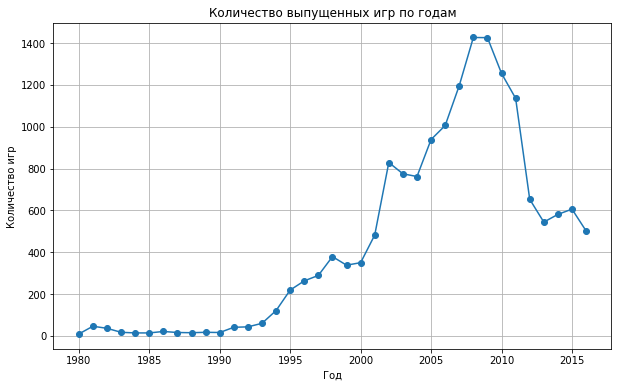

In [20]:
# построим график динамики выпуска игр по годам
plt.figure(figsize=(10, 6))

# строим сводную таблицу, считаем кол-во выпущенных игр по годам
data_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.plot(data_year, marker='o')
plt.grid(True)

# зададим названия осям и графику
plt.title('Количество выпущенных игр по годам') 
plt.xlabel('Год')
plt.ylabel('Количество игр')


plt.show()

Количество выпускаемых игр начало плавно расти с 1990 года, до 1990 число игр практически не менялось, это обусловлено инновациями в сфере видеоигр в 90-х годах, созданием новых поколений консолей и появлением новых жанров в играх. Рост выпуска сохраняется до 2008 года, в котором наблюдается пие количества выпущенных игр, затем показатель достаточно резко идет на спад. Это может быть связано с мировым экономическим кризисом 2008 года.

### Суммарные продажи в разрезе платформ

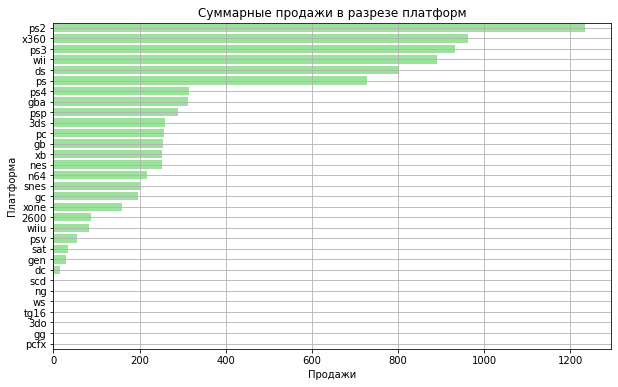

In [21]:
# задаем размер графика
plt.figure(figsize=(10, 6))

# строи сводную таблицу с суммарными продажами в разрезе платформ
data_platform = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

# строим график по полученным данным
sns.barplot(y=data_platform.index, x='total_sales', data=data_platform, color='lightgreen');
plt.grid(True)
   
plt.title('Суммарные продажи в разрезе платформ')
plt.xlabel('Продажи')
plt.ylabel('Платформа')


plt.show()

На графике видно, что с большим отрывом от остальных лидируют 6 платформ: PS2, X360, PS3, WII, DS и PS. На примере этих платформ рассмотрим жизненный цикл платформ.

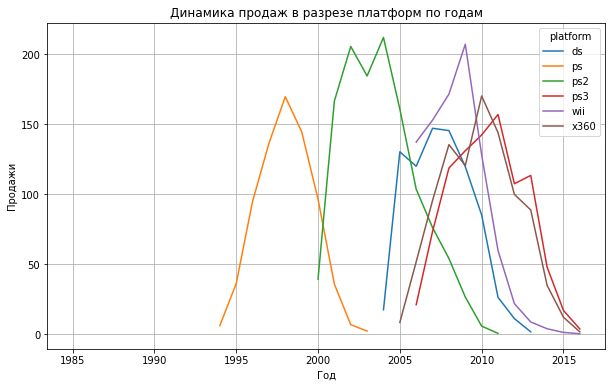

In [22]:
# сохраняем список платформ-лидеров в переменную
big_platform = ['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps']

# считаем суммарные продажи по избранным платформам с помощью сводной таблицы
data_pl_inc = data.query('platform in @big_platform').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

# строим график 
data_pl_inc.plot(figsize=(10, 6));
plt.grid(True)
   
plt.title('Динамика продаж в разрезе платформ по годам')
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.show()

По графику видно, что в среднем консоль живет 10-11 лет: примерно первые 5 лет происходит рост числа выпускаемых игр, затем снижение популярности консоли и продаж и одновременно с этим появление новой консоли.

Так как новые консоли появляются, а старые исчезают примерно каждые пять лет, для анализ будем считать актуальным период с 2013 по 2016 г.

In [23]:
# создаем датафрейм с данными из актуального периода
data_itog = data.query('year_of_release >= 2013 and year_of_release <= 2016')

### Потенциально прибыльные платформы

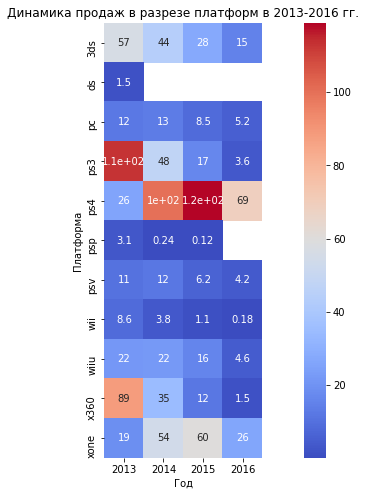

In [24]:
plt.figure(figsize = (15,8))

# считаем суммарные продажи в разрезе платформ в актуальном периоде
data_itog_pivot = data_itog.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')

# строим тепловую карту по полученным данным
sns.heatmap(data_itog_pivot,  square = True, annot = True, cmap="coolwarm");

plt.title('Динамика продаж в разрезе платформ в 2013-2016 гг.');
plt.xlabel('Год');
plt.ylabel('Платформа');


Согласно тепловой карте можно выделить несколько лидирующих к 2016г. платформ: PS4, XOne, 3DS, WIIU, PC. Однако большая часть платформ к 2016 году уже пошли на спад или вовсе перестали производить игры. 

### Глобальные продажи игр в разбивке по платформам

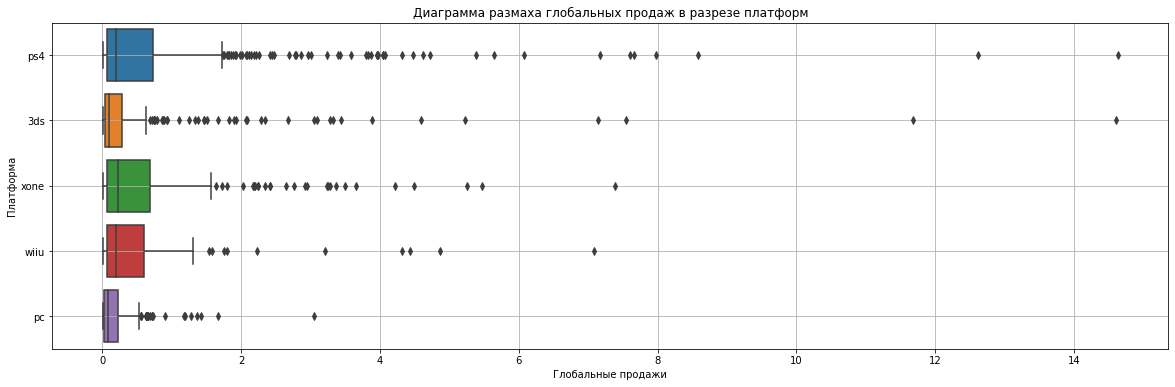

In [25]:
plt.figure(figsize = (20,6))

# запишем платформы-лидеры в переменную
platform = ['3ds', 'ps4', 'xone', 'wiiu', 'pc']

# возтмем только данные по платформам-лидерам
data_pl = data_itog.query('platform in @platform')

# построим "ящик с усами" по полученным данным
sns.boxplot(data=data_pl, y='platform', x='total_sales');
plt.grid(True)
   
plt.title('Диаграмма размаха глобальных продаж в разрезе платформ');
plt.xlabel('Глобальные продажи');
plt.ylabel('Платформа');


В данных наблюдается большое число выбросов - аномально крупныех продаж. Рассмотрим подробнее диаграммы рассеяния, ограничив их по оси х.

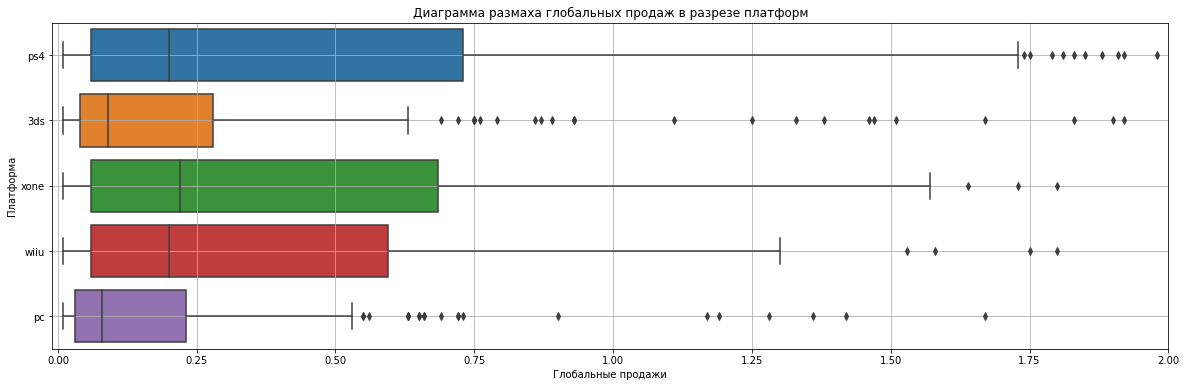

In [26]:
plt.figure(figsize = (20,6))

sns.boxplot(data=data_pl, y='platform', x='total_sales');
plt.xlim(-0.01, 2)
plt.grid(True)
   
plt.title('Диаграмма размаха глобальных продаж в разрезе платформ');
plt.xlabel('Глобальные продажи');
plt.ylabel('Платформа');

Можно выделить три платформы с наибольшими глобальными продажами - PS4, XOne, WIIU. Медианные значения и сами "ящики" этих платформ больше, чем у остальных.

### Влияние оценок пользователей и оценок критиков на продажи

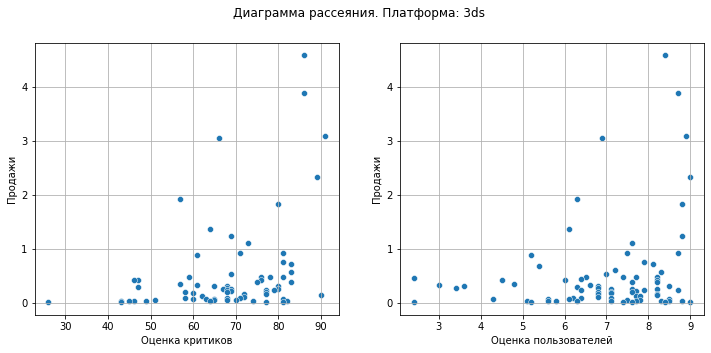

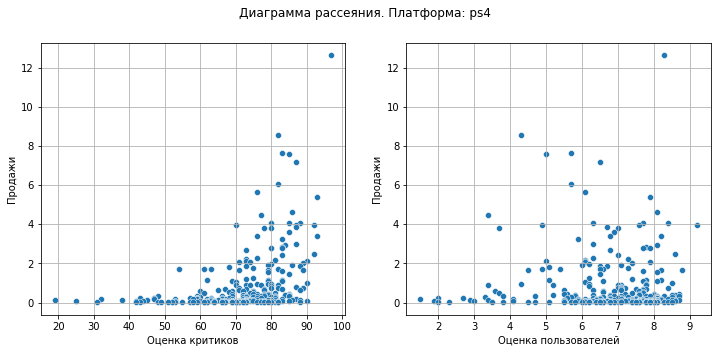

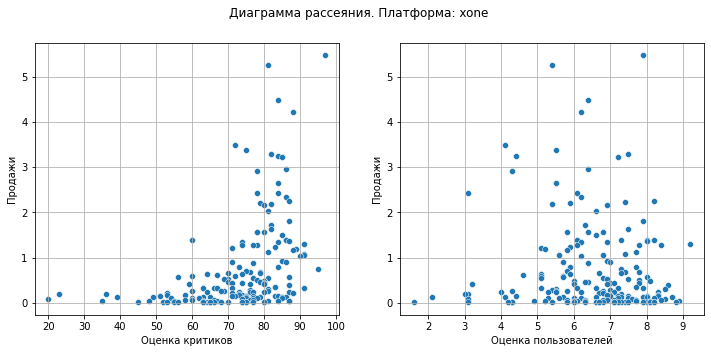

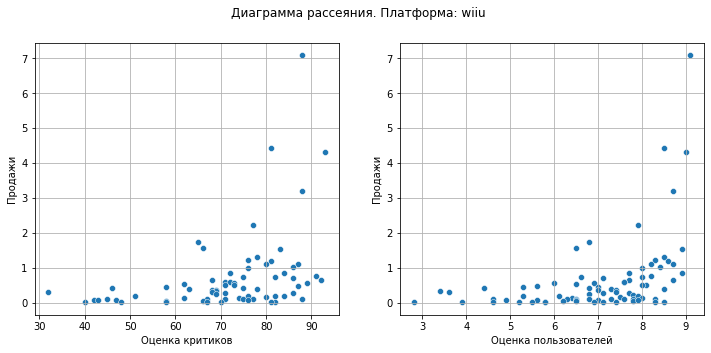

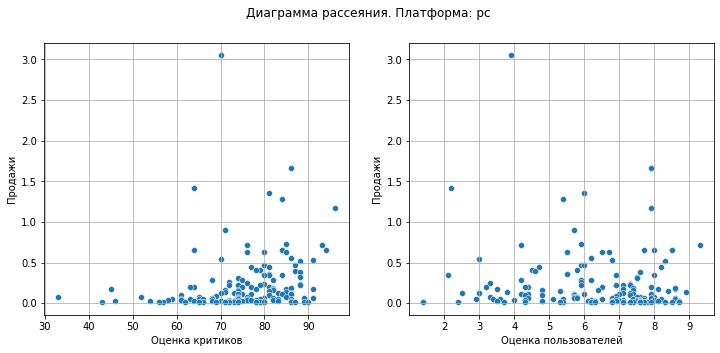

In [27]:
# напишем функцию для построения двух диаграмм рассеняия: продажи-оценки критиков, продажи-оценки пользователей
def show_plot(df, platform):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    plt.subplot (1, 2, 1)
    sns.scatterplot(x='critic_score', y=df.loc[(df['platform'] == platform)&(df['critic_score'] != -1)]['total_sales'], data=df)
    plt.grid(True)
    plt.xlabel('Оценка критиков');
    plt.ylabel('Продажи');
    
    plt.subplot (1, 2, 2)
    sns.scatterplot(x='user_score', y=df.loc[(df['platform'] == platform)&(df['user_score'] != -5)]['total_sales'], data=df)
    plt.grid(True)
    plt.xlabel('Оценка пользователей');
    plt.ylabel('Продажи');
    
    plt.suptitle('Диаграмма рассеяния. Платформа: {}'.format(platform))
    
# с помощью цикла переберем все столбцы с признаками и построим графики
for pl in platform:
    show_plot(data_pl, pl)

В соответствии с полученными диаграммами можно сказать, что большее влияние на продажи игр оказывают оценки критиков, с их ростом увеличивается и объем продаж. Значительное влияние на продажи как оценок критиков, так и оценок пользователей можно заметить у платформы WIIU, а наименьшую зависимость от оценок у платформы PC.

Рассмотрим такде коэффициенты корреляции по каждой платформе.

In [28]:
# с помощью цикла посчитаем коэф. корреляции для каждой платформы
for pl in platform:
    cor_critic_score = data_pl.loc[(data_pl['platform'] == pl)&(data_pl['critic_score'] != -1)]['total_sales'].corr(data_pl['critic_score'])
    cor_user_score = data_pl.loc[(data_pl['platform'] == pl)&(data_pl['user_score'] != -5)]['total_sales'].corr(data_pl['user_score'])
    print('Коэффицент корреляции для отзывов критиков. Платформа {}: {}'.format(pl, '%.2f' % cor_critic_score))
    print('Коэффицент корреляции для отзывов пользователей. Платформа {}: {}'.format(pl, '%.2f' % cor_user_score))
    print()

Коэффицент корреляции для отзывов критиков. Платформа 3ds: 0.36
Коэффицент корреляции для отзывов пользователей. Платформа 3ds: 0.24

Коэффицент корреляции для отзывов критиков. Платформа ps4: 0.41
Коэффицент корреляции для отзывов пользователей. Платформа ps4: -0.03

Коэффицент корреляции для отзывов критиков. Платформа xone: 0.42
Коэффицент корреляции для отзывов пользователей. Платформа xone: -0.07

Коэффицент корреляции для отзывов критиков. Платформа wiiu: 0.38
Коэффицент корреляции для отзывов пользователей. Платформа wiiu: 0.42

Коэффицент корреляции для отзывов критиков. Платформа pc: 0.20
Коэффицент корреляции для отзывов пользователей. Платформа pc: -0.09



Как было сказано выше, наиболее сильная корреляция одновременно между продажами и оценками как критиков, так и пользователей у платформы WIIU, однако корреляция продаж с оценками критиков сильнее у платформы XOne и PS4. В целом можно сказать, что оценки пользователей почти не оказывают влияния на продажи, а оценки критиков оказывают умеренное влияние. Таким образом, игры с более высокими оценками критиков с большой вероятностью будут продаваться лучше.

### Распределение игр по жанрам

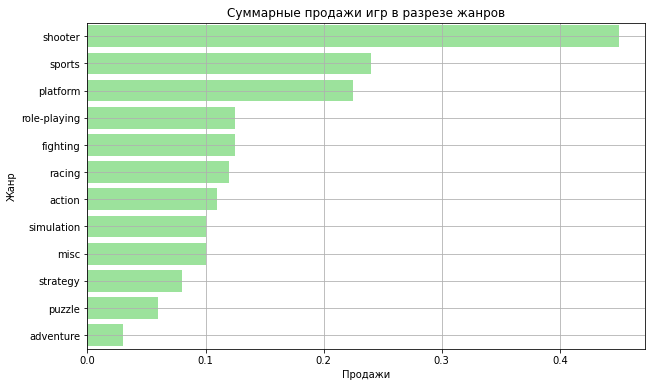

In [29]:
plt.figure(figsize=(10, 6))

# строим сводную таблицу с суммарными продажами в разрезе жанров игр
data_genre = data_itog.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False)

# строим столбчатую диаграмму
sns.barplot(y=data_genre.index, x='total_sales', data=data_genre, color='lightgreen');
plt.grid(True)
   
plt.title('Суммарные продажи игр в разрезе жанров')
plt.xlabel('Продажи')
plt.ylabel('Жанр')


plt.show()

Наиболее популярными жанрами игр во всем мире являются: 'shooter', 'sports','platform', 'role-playing', у них самые большие медианные продажи. Менее всего пользуются спросом 'puzzle' и 'adventure'.

## Портрет пользователя каждого региона

### Популярные платформы

In [30]:
# готовим данные для графика: считаем для каждого региона долю каждой платформы в общем объеме продаж
reg_na = data_itog.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
reg_na['share'] = round(reg_na['na_sales'] / reg_na['na_sales'].sum() * 100, 1)

reg_eu = data_itog.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
reg_eu['share'] = round(reg_eu['eu_sales'] / reg_eu['eu_sales'].sum() * 100, 1)

reg_jp = data_itog.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
reg_jp['share'] = round(reg_jp['jp_sales'] / reg_jp['jp_sales'].sum() * 100, 1)

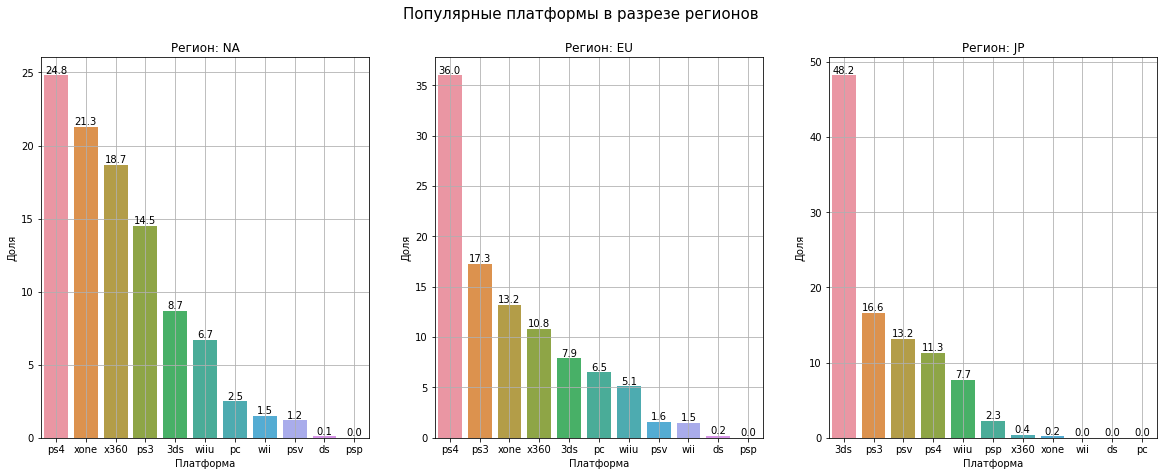

In [31]:
# построим график для каждого региона 
plt.figure(figsize=(20, 7))
plt.suptitle('Популярные платформы в разрезе регионов', fontsize=15)

# строим график для регона NA
plt.subplot(1, 3, 1)
sns.barplot(data=reg_na, x=reg_na.index, y='share')
plt.title('Регион: NA')
plt.ylabel('Доля')
plt.xlabel('Платформа')
plt.grid(True)
for index, value in enumerate(reg_na['share']):
        plt.text(index, value, str(value), ha='center', va='bottom') #подписываем значения на графике

# строим график для регона EU
plt.subplot(1, 3, 2)
sns.barplot(data=reg_eu, x=reg_eu.index, y='share')
plt.title('Регион: EU')
plt.ylabel('Доля')
plt.xlabel('Платформа')
plt.grid(True)
for index, value in enumerate(reg_eu['share']):
        plt.text(index, value, str(value), ha='center', va='bottom') #подписываем значения на графике

# строим график для регона JP        
plt.subplot(1, 3, 3)
sns.barplot(data=reg_jp, x=reg_jp.index, y='share')
plt.title('Регион: JP')
plt.ylabel('Доля')
plt.xlabel('Платформа')
plt.grid(True)
for index, value in enumerate(reg_jp['share']):
        plt.text(index, value, str(value), ha='center', va='bottom') #подписываем значения на графике

Для каждого региона можно выделить платформы-лидеры:

1) Северная Америка:
- X360
- PS4
- PS3
- XONE
- 3DS

Остальные платформы занимают значительно меньшие доли в общей сумме продаж.

2) Европа:
- PS4
- PS3
- X360
- XONE
- 3DS

В Европе разница меджду платформами менее заметна, чем в Северной Америке и Японии. При этом лидеры в Европе и Северной Америке одни и те же, отличаются только позиции в топе. И там, и там на 5 месте оказалась платформа 3DS.

3) Япония:
- 3DS
- PS3
- PSV
- PS4
- WIIU

Абсолютным лидером по продажам в Японии является 3DS, там же и произведенная. Далее идут платформы от PlayStation разных поколений, а вот консоли Xbox наименее популярны у японцев.

### Популярные жанры

In [32]:
# готовим данные для графика: считаем для каждого региона долю каждого жанра в общем объеме продаж
gen_na = data_itog.pivot_table(index='genre', values='na_sales', aggfunc='median').sort_values(by='na_sales', ascending=False)
gen_na['share'] = round(gen_na['na_sales'] / gen_na['na_sales'].sum() * 100, 1)

gen_eu = data_itog.pivot_table(index='genre', values='eu_sales', aggfunc='median').sort_values(by='eu_sales', ascending=False)
gen_eu['share'] = round(gen_eu['eu_sales'] / gen_eu['eu_sales'].sum() * 100, 1)

gen_jp = data_itog.pivot_table(index='genre', values='jp_sales', aggfunc='median').sort_values(by='jp_sales', ascending=False)
gen_jp['share'] = round(gen_jp['jp_sales'] / gen_jp['jp_sales'].sum() * 100, 1)

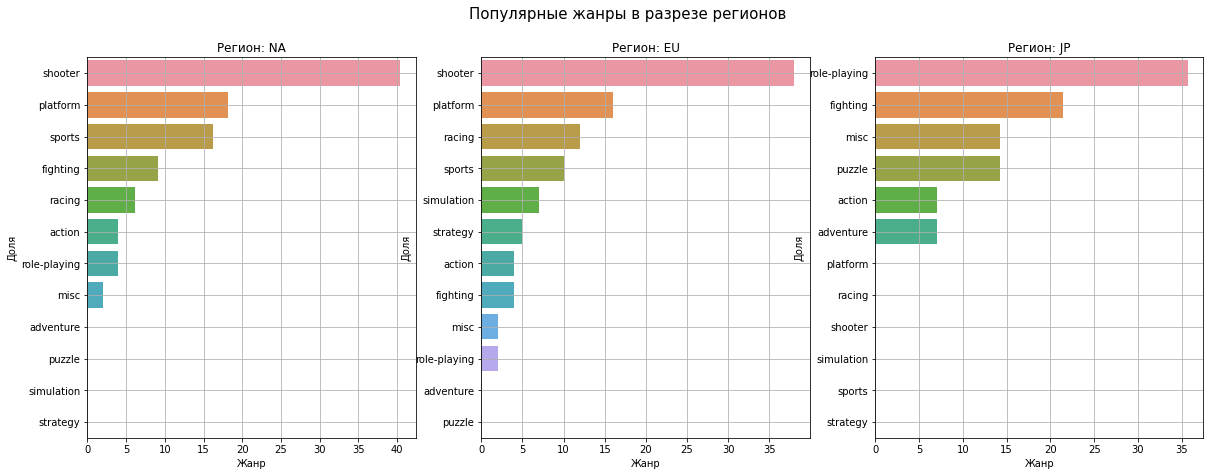

In [33]:
plt.figure(figsize=(20, 7))
plt.suptitle('Популярные жанры в разрезе регионов', fontsize=15)

# строим график для регона NA
plt.subplot(1, 3, 1)
sns.barplot(data=gen_na, y=gen_na.index, x='share')
plt.title('Регион: NA')
plt.ylabel('Доля')
plt.xlabel('Жанр')
plt.grid(True)

# строим график для регона EU
plt.subplot(1, 3, 2)
sns.barplot(data=gen_eu, y=gen_eu.index, x='share')
plt.title('Регион: EU')
plt.ylabel('Доля')
plt.xlabel('Жанр')
plt.grid(True)

# строим график для регона JP        
plt.subplot(1, 3, 3)
sns.barplot(data=gen_jp, y=gen_jp.index, x='share')
plt.title('Регион: JP')
plt.ylabel('Доля')
plt.xlabel('Жанр')
plt.grid(True)

Для каждого региона выделим жанры-лидеры:

1) Северная Америка:
- shooter
- platform
- sports
- fighting
- racing

2) Европа:
- shooter
- platform
- racing
- sports
- simulation

Первые 4 позиции в топе у Северной Америки и Европе идентичны.

3) Япония:
- role-playing
- fighting
- misc
- puzzle
- action

Топ жанров в Японии заметно отличается от Европы и Северной Америки. Различие менталитета и культуры определяют наиболее интересные для пользователей жанры. 

### Влияние рейтинга ESRB на продажи

In [34]:
# готовим данные для графика: считаем для каждого региона продажи игр с разными рейтингами
rat_na = data_itog.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
rat_na['share'] = round(rat_na['na_sales'] / rat_na['na_sales'].sum() * 100, 1)

rat_eu = data_itog.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
rat_eu['share'] = round(rat_eu['eu_sales'] / rat_eu['eu_sales'].sum() * 100, 1)

rat_jp = data_itog.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
rat_jp['share'] = round(rat_jp['jp_sales'] / rat_jp['jp_sales'].sum() * 100, 1)

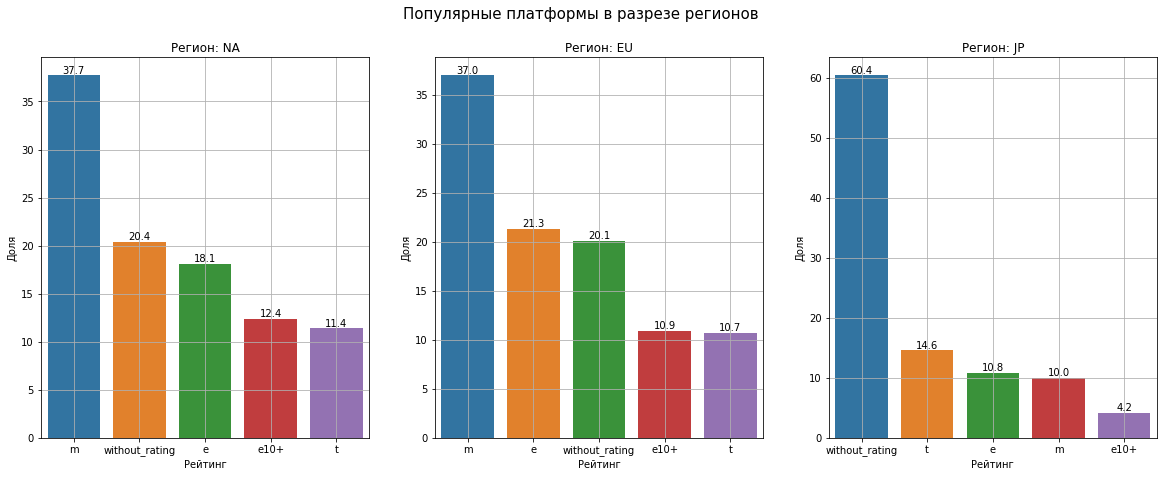

In [35]:
# построим график для каждого региона 
plt.figure(figsize=(20, 7))
plt.suptitle('Популярные платформы в разрезе регионов', fontsize=15)

# строим график для регона NA
plt.subplot(1, 3, 1)
sns.barplot(data=rat_na, x=rat_na.index, y='share')
plt.title('Регион: NA')
plt.ylabel('Доля')
plt.xlabel('Рейтинг')
plt.grid(True)
for index, value in enumerate(rat_na['share']):
        plt.text(index, value, str(value), ha='center', va='bottom') #подписываем значения на графике

# строим график для регона EU
plt.subplot(1, 3, 2)
sns.barplot(data=rat_eu, x=rat_eu.index, y='share')
plt.title('Регион: EU')
plt.ylabel('Доля')
plt.xlabel('Рейтинг')
plt.grid(True)
for index, value in enumerate(rat_eu['share']):
        plt.text(index, value, str(value), ha='center', va='bottom') #подписываем значения на графике

# строим график для регона JP        
plt.subplot(1, 3, 3)
sns.barplot(data=rat_jp, x=rat_jp.index, y='share')
plt.title('Регион: JP')
plt.ylabel('Доля')
plt.xlabel('Рейтинг')
plt.grid(True)
for index, value in enumerate(rat_jp['share']):
        plt.text(index, value, str(value), ha='center', va='bottom') #подписываем значения на графике

Значения рейтингов:

- M (от 17 лет и старше)
- E (для всех возрастов)
- E10+ (от 10 лет и старше)
- T (от 13 лет и старше)


Можно заметить, что распределение игр по рейтингам в Европе и Северной америке совпадают, наибольшую долю занимают игры от 17 лет и старше и игры для все возрастов. В Японии преобладают игры для всех возрастов и от 13 лет, однако в Японии большая доля игр без возастного рейтинга. Это связано с тем, что в Японии существуют свои рейтинговые агенства - CERO и EOCS, которые и устанавливают возрастные ограничения.

## Гипотезы

- H0 формулируют так, чтобы использовать знак равенства.
- Альтернативная гипотеза H1 формулируется на основании нулевой гипотезы. Это утверждение, которое принимается верным, если отвергается H0

Для проверки гипотез значение alpha примем равным 0.5, и будем использовать метод проверки ttest_ind, так как в обеих гипотезах сравниваются 2 независимые генеральные совокупности.

### Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0 - пользовательские рейтинги Xbox One и PC РАВНЫ

H1 - пользовательские рейтинги Xbox One и PC ОТЛИЧАЮТСЯ

Сравним размеры выборок, для того чтобы выбрать правильное значение параметра equal_var

In [36]:
# отбираем данные, в которых не производилось заполнение пропусков в стоблце user_score
data_hyp = data_itog.query('user_score != -5')

In [37]:
print('Размер совокопуности для Xbox One:', len(data_hyp.query('platform == "xone"')['user_score']))
print('Размер совокопуности для PC:', len(data_hyp.query('platform == "pc"')['user_score']))

Размер совокопуности для Xbox One: 182
Размер совокопуности для PC: 155


Размеры выборок достаточно сильно различаются, поэтому примем значение equal_var равным False.

In [38]:
alpha = 0.05 # задаем уровень статистической значимости

# рассчитываем p-value
results = st.ttest_ind(data_hyp.query('platform == "xone"')['user_score'], data_hyp.query('platform == "pc"')['user_score'], equal_var=False)

print('p-значение:', results.pvalue) #выводим значение p-value

# сравниваем полученное p-value с уровнем значимости
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


По итогам проверки гипотез мы не можем отвергнуть нулевую гипотезу, то есть средние пользовательскте оценки платформ Xbox One и PC равны.

### Гипотеза: средние пользовательские рейтинги жанров Action и Sports разные

Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

H0 - пользовательские рейтинги жанров Action и Sports равны

H1 - пользовательские рейтинги жанров Action и Sports разные

Сравним размеры выборок, для того чтобы выбрать правильное значение параметра equal_var

In [39]:
print('Размер совокопуности для ACTION:', len(data_hyp.query('genre == "action"')['user_score']))
print('Размер совокопуности для SPORTS:', len(data_hyp.query('genre == "sports"')['user_score']))

Размер совокопуности для ACTION: 389
Размер совокопуности для SPORTS: 160


Размеры выборок очень сильно отличаются, поэтому параметр equal_var примем равным False

In [40]:
alpha = 0.05 # задаем уровень статистической значимости

# рассчитываем p-value
results = st.ttest_ind(data_hyp.query('genre == "action"')['user_score'], data_hyp.query('genre == "sports"')['user_score'], equal_var=False)

print('p-значение:', results.pvalue) #выводим значение p-value

# сравниваем полученное p-value с уровнем значимости
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


По итогам теста мы отвергаем нулевую гипотезу, то есть пользовательские рейтинги Action и Sports отличаются.

## Вывод

Был проведен исследовательский анализ данных, в ходе которого было установлено:
1.	Жизненный цикл игровых платформ - 10-11 лет. Причем примерно каждые 5 лет появляется новая платформа
2.	Потенциально прибыльными платформами являются PS4, XOne, 3DS, WIIU, PC
3.	Оценки пользователей практически не влияют на продажи игр, а вот оценки критиков оказывают умеренное прямое влияние, т.е. Чем выше оценка критиков, тем выше продажи
4.	Наиболее популярные во всем мире жанры: 'shooter', 'role-playing' и 'sports'

Так же необходимо помнить о различиях между пользователями из разных регионов и учитывать их специфику, в том числе популярные в отдельном регионе консоли, жанры и возрастные рейтинги. Перспективные направления в разных регионах:

- Северная Америка:
	-	Платформы:  Xbox и PlayStation
	-	Жанры:  shooter, platform
	-	Возрастные рейтинги:  M, E
- Европа:
	-	Платформы:  PlayStation и Xbox
	-	Жанры:  shooter, platform
	-	Возрастные рейтинги:  M, E
- Япония:
	-	Платформы: 3DS и  PlayStation
	-	Жанры:  role-playing, fighting
	-	Возрастные рейтинги:   E, T
